In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt

import numpy as np

## Problem Statement

This notebook describes the implementation of a quantum computer. The algorithms for addition and multiplication are based on those described in the papers https://arxiv.org/pdf/quant-ph/0008033 and https://arxiv.org/pdf/1411.5949.

Let $|a\rangle \in F_2^n \simeq Z_{2^n}$ with $|a\rangle = |a_1\rangle \otimes \ldots \otimes |a_n\rangle$.

We write a Qiskit function that takes one input: a positive integer $n$ and outputs a quantum circuit, QCalc, on $3n +1$ qubits, possibly with further ancillas, that implements the following:

\begin{equation}
\text{QCalc}|a\rangle_n |b\rangle_n |z\rangle_1 |0\rangle_n = \begin{cases} |a\rangle_n |b\rangle_n |z\rangle_1 |a+b \quad \text{mod} \quad 2^n\rangle_n \quad z = 0 \\ |a\rangle_n |b\rangle_n |z\rangle_1 |a\cdot b \quad \text{mod} \quad 2^n\rangle_n, \quad z = 1\end{cases}
\end{equation}

The notebook is structured as follows. Section 1 blablabla

# Table of Contents
1. [Helper Functions](#HelperFunctions)
2. [Quantum Fourier Transform](#FT)
2. [Quantum Addition](#add)
3. [Quantum Multiplication](#mult)
4. [Quantum Calculator](#add+mult)
5. [Analysis of Complexities](#complexities)

## Helper Functions and Basic Gates <a name = "HelperFunctions"></a>

The following helper functions are used when we evaluate the quantum circuits (addition or multiplication) numerically with different initial conditions. These helper functions convert back and forth between bit-strings, state vectors and numbers.

In [2]:
def bit_string(num,n): # converts a number to binary bit_string
    """Converts a number to its binary string with MSB to LSB from left to right.
    Input: number (num), n (number of bits that should be in result)
    """
    maxi = 2**n
    rem = num%(2**n)

    bit_string = ''# 2^(n-1) ... 2^0 

    for i in range(n-1,-1,-1):
        append = str(rem//(2**i))
        bit_string = bit_string + append
        rem = rem%(2**i)
    return bit_string

def binary_to_num(bit_str):
    """Convert a bit-string to a number.
    Input : bit-string in binary
    Output: number 
    """
    num=0
    n=len(bit_str)
    
    for i in range(n):
        bit = int(bit_str[i])
        if bit < 0 or bit > 1:
            print("Fatal error. You did not input a bit string.Exiting.")
            return 0
        num = num + bit*2**(n-1-i)
    return num

def number_input(num1,num2,z,n,nA): # converts number input to statevector. n is number of qubits.
    """Converts num1 to binary, num2 to binary, concatenates the bit-strings, and adds n (number of bits) 
    trailing zeroes and nA (number of ancilla qubits) trailing zeroes to the bit-string.
    """
    
    
    bit_str = bit_string(num1,n)[::-1] + bit_string(num2,n)[::-1] + str(int(z))+''.join(['0' for i in range(n+nA)]) # the two zeroes are the |0>_d and ancillas
    
    return bit_to_state(bit_str)

def bit_to_state(bit_str): #convert bit_string to state_vector
    """ Converts a bit-string to an input state vector for the circuit.
    """
    bit_str = bit_str[::-1]
    #
    return Statevector.from_label(bit_str)
def state_to_bit(statevector,n): # converts state_vector to bit_string
    """ Converts an input statevector to a bit-string of length n
    """
    num = np.nonzero(np.round(np.real(statevector)))[0][0]
   
    return bit_string(num,n)
    
def result(output_statevector,n, nA):
    """Outputs the number that is stored in the last n bits of the bit-string of a statevector for the QC.
    This function is used to read in the result of the multiplication or addition performed by the QC.
    """
    #remove ancillas
    output_number_bit_str = state_to_bit(output_statevector,3*n+1+nA)[nA : nA + n]
    
    return binary_to_num(output_number_bit_str)

### Construction of Necessary Gates

In order to use CP, CCP, and CCCP gates we will construct them out of CX, P, and CCX gates

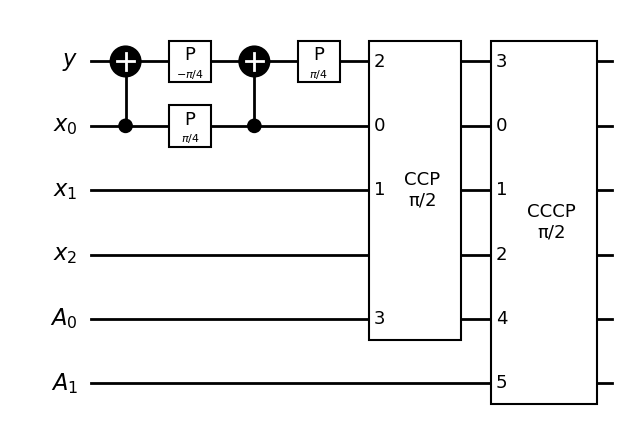

In [4]:
# Now let's try to make this into a function for arbitrary number of qubits n.

#cp gate 
def cp(qc, control, target, phase):
    qc.cx(control, target)
    qc.p(phase/2, control)
    qc.p(- phase/2, target)
    qc.cx(control, target)
    qc.p(phase / 2, target)

#ccp gate
def ccp(qc, controls, target, ancilla ,phase):
    qc.ccx(controls[0],controls[1],ancilla)
    cp(qc, ancilla, target, phase)

#ccp gate
def ccp(qc, controls, target, ancilla ,phase): 
    qc.ccx(controls[0],controls[1],ancilla)
    cp(qc, ancilla, target, phase)

def ccp_gate(qc, controls, target, ancilla, phase):
    qc_contr= QuantumRegister(2)
    qc_target = QuantumRegister(1)
    qc_ancilla = AncillaRegister(1)
    if np.pi/phase%1==0:
        temp_int=str(int(np.pi/phase))
        if temp_int == "1":
            qc_Temp = QuantumCircuit(qc_contr, qc_target, qc_ancilla, name="CCP\n"+"π")
        else:
            qc_Temp = QuantumCircuit(qc_contr, qc_target, qc_ancilla, name="CCP\n"+"π/"+temp_int)
    else: 
        qc_Temp = QuantumCircuit(qc_contr, qc_target, qc_ancilla, name="CCP\n"+str(round(phase,2)))
    ccp(qc_Temp, qc_contr, qc_target, qc_ancilla, phase)
    qc_Temp.to_gate()
    qc.append(qc_Temp,qargs=[controls[0],controls[1], target, ancilla])


#cccp gate
def cccp(qc, controls, target, ancillas ,phase):
    qc.ccx(controls[0],controls[1],ancillas[0])
    qc.ccx(controls[2],ancillas[0],ancillas[1])
    cp(qc, ancillas[1], target, phase)

def cccp_gate(qc, controls, target, ancillas, phase):
    qc_contr= QuantumRegister(3)
    qc_target = QuantumRegister(1)
    qc_ancilla = AncillaRegister(2)
    if np.pi/phase%1==0:
        temp_int=str(int(np.pi/phase))
        if temp_int == "1":
            qc_Temp = QuantumCircuit(qc_contr, qc_target, qc_ancilla, name="CCCP\n"+"π")
        else:
            qc_Temp = QuantumCircuit(qc_contr, qc_target, qc_ancilla, name="CCCP\n"+"π/"+temp_int)
    else: 
        qc_Temp = QuantumCircuit(qc_contr, qc_target, qc_ancilla, name="CCCP\n"+str(round(phase,2)))
    cccp(qc_Temp, qc_contr, qc_target, qc_ancilla, phase)
    qc_Temp.to_gate()
    qc.append(qc_Temp,qargs=[controls[0],controls[1],controls[2], target, ancillas[0], ancillas[1]])


qc_a2 = QuantumRegister(size=3, name="x")
qc_a1 = QuantumRegister(size=1, name="y")
qc_Anc = AncillaRegister(size=2, name="A")

qcTest = QuantumCircuit(qc_a1, qc_a2, qc_Anc,name="QFT circuit")
cp(qcTest, qc_a2[0], qc_a1[0], np.pi/2)
ccp_gate(qcTest, [qc_a2[0],qc_a2[1]], qc_a1[0],qc_Anc[0], np.pi/2)
cccp_gate(qcTest, [qc_a2[0],qc_a2[1],qc_a2[2]], qc_a1[0],[qc_Anc[0],qc_Anc[1]], np.pi/2)
qcTest.draw(output="mpl", style="bw")


## Quantum Fourier Transform (QFT) <a name = "FT"></a>

The Fourier transform for $|a\rangle \in {|0\rangle,|1\rangle,\ldots,|2^n-1\rangle}$ (with $n$ the number of qubits) is defined as 
\begin{equation}
|\phi(a)\rangle \equiv QFT \, |a\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0} e^{i 2\pi a k /2^n} \,|k\rangle
\end{equation}
If we define
\begin{equation}
|\phi_k(a)\rangle = \frac{1}{\sqrt{2}} (|0\rangle + e^{2 \pi i a /2^k}|1\rangle)
\end{equation}
then it can be shown that the Fourier Transform is simply a tensor product.
\begin{equation}
|\phi(a)\rangle = \frac{1}{\sqrt{2^n}} |\phi_n (a)\rangle \otimes \ldots \otimes |\phi_1(a)\rangle
\end{equation}
We can write $a$ in its bit string representation as $a = a_1 2^0 + a_2 2^2 + \ldots + a_n 2^{n-1}$. Then,
\begin{align}
e^{2\pi i a/2^k} &= e^{2\pi i \sum_j a_j 2^{j-1}/2^k} \\
&= e^{2\pi i \sum_j a_j 2^{j-k-1}} \\
&= \prod_{j=1}^{k} e^{2\pi i a_j 2^{j-k-1}}
\end{align}
where in the last line we used that $j \leq k$ since otherwise the phase is just equal to 1. Hence we see that obtaining the $|\phi_k(a)\rangle$ constitutes to (i) applying a Hadamard gate to transform $|0\rangle \to \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ and (ii) applying a composition of $k$ rotations controlled on the qubit $a_j$. These rotations are implemented as 2-qubit unitary gates $R_k$ which are defined as
\begin{equation}
R_k = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{2\pi i /2^k} \end{pmatrix}
\end{equation}
The QFT is thus a unitary linear transformation. Below is the standard implementation of the QFT.

The \emph{Inverse Quantum Fourier Transform} (IQFT) can be implemented as the inverse of the QFT transformation. $IQFT = QFT^{-1} = QFT^\dagger$. Practically, it is given by retracing the gates in the quantum gates in the circuit in the opposite direction, and replacing any gate by its inverse.

Below we give the standard implementation of the QFT and IQFT. We verify that it works for a 2-qubit system with $n=2$ by verifying the identity $QFT \cdot IQFT = I$ where $I$ is the identity.

In [5]:
def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            #QFT_circuit.cp(np.pi / (1 << j), q, p) # Symmetric so does not matter.
            phase=np.pi / (1 << j)
            cp(QFT_circuit, q, p, phase)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)
    
    return QFT_circuit

def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)
        
    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            #inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
            phase=-np.pi / (1 << (i-j))
            cp(inverse_QFT_circuit, q, p, phase)
        inverse_QFT_circuit.h(q)

    

    return inverse_QFT_circuit

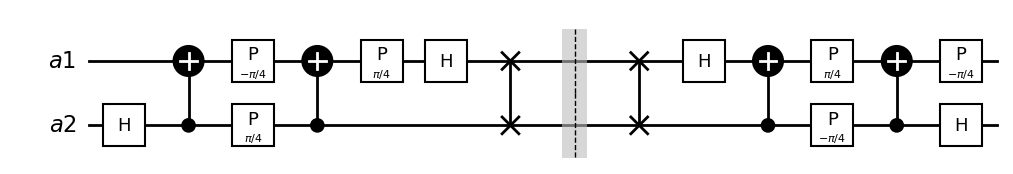

In [6]:
#Check that QFT works
qc_a2 = QuantumRegister(size=1, name="a2")
qc_a1 = QuantumRegister(size=1, name="a1")


#QFT_circuit = QuantumCircuit(qc_c2, qc_c1, qc_b2, qc_b1, qc_a2, qc_a1, name="QFT circuit")
QFT_circuit = QuantumCircuit(qc_a1, qc_a2,name="QFT circuit")
QFT_circuit.compose(quantum_fourier_transform(2), qubits = [1,0],inplace=True)
QFT_circuit.barrier()
QFT_circuit.compose(inverse_quantum_fourier_transform(2), qubits = [1,0],inplace=True)
#QFT_circuit.swap(0,1)
QFT_circuit.draw(output="mpl", style="bw")

In [7]:
Operator(QFT_circuit) # this should give identity.

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


As expected, we get that $QFT \cdot IQFT = I$.

## Quantum Addition <a name = "add"></a>

Let's find a QC that implements QC$|a\rangle |b\rangle |c\rangle = |a\rangle |b\rangle |a+b+c \quad \text{mod} \quad 2^n\rangle$ (we will set $c=0$ in the end). Notation : We suppress the subscript $n$ on these qudits.

We claim that QC = $IQFT_{c} CZ_{a,c}CZ_{b,c} QFT_c$ where 
\begin{equation}
CZ |x\rangle |y\rangle \equiv e^{i 2\pi x y/2^n}|x\rangle |y\rangle
\end{equation}

Let us apply each transformation in the order that they appear.

\begin{equation}
QFT_c |a\rangle |b\rangle |c\rangle = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} e^{i 2\pi c k /2^n} |a\rangle |b\rangle |k\rangle
\end{equation}
Then,
\begin{align}
CZ_{b,c} QFT_c |a\rangle |b\rangle |c\rangle &= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} e^{i 2\pi c k /2^n} |a\rangle CZ_{b,k}|b\rangle |k\rangle \\
&= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} e^{i 2\pi (b+c) k /2^n} |a\rangle |b\rangle |k\rangle
\end{align}
Similarly, then,
\begin{align}
CZ_{a,c} CZ_{b,c} QFT_c |a\rangle |b\rangle |c\rangle &= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} e^{i 2\pi (a+b+c) k /2^n} |a\rangle |b\rangle |k\rangle \\
&= |a\rangle |b\rangle |\phi(a+b+c)\rangle
\end{align}
So, that, finally,
\begin{equation}
IQFT_c CZ_{a,c} CZ_{b,c} QFT_c |a\rangle |b\rangle |c\rangle = |a\rangle |b\rangle |a+b+c \quad \text{mod} \quad 2^n\rangle 
\end{equation}
Crucially, we see that addition is just a rotation in Fourier space. Defining $A = a + b +c$, this is exactly one of the equations we saw in the section on [QFT](#FT), and we can write
\begin{equation}
|\phi_k(A)\rangle = \frac{1}{\sqrt{2}} (|0\rangle + e^{2\pi i A /2^k} |1\rangle)
\end{equation}
or 
\begin{equation}
|\phi(a+b+c)\rangle = \frac{1}{\sqrt{2}} (|0\rangle + e^{2\pi i a/2^k} e^{2 \pi i b/2^k} e^{2\pi i c/2^k} |1\rangle)
\end{equation}
Setting $c=0$, the phase changes are
\begin{equation}
e^{2\pi i a/2^k} e^{2 \pi i b/2^k} = \prod_{j=1}^k e^{2\pi i a_j 2^{j-k-1}} e^{2\pi i b_j 2^{j-k-1}}
\end{equation}
Hence to implement addition, we only need to perform the rotations using the matrices $R_k$ (defined in section [QFT](#FT)) where for each rotation that gets controlled by $a_j$, we now also have a corresponding rotation that is controlled by $b_j$. This will transform $\phi(0) \to \phi(a+b)$.

Below we give the qiskit implentation using the algorithm described. For now, we use Qiskit's CP gate and use our own in the final build.

In [8]:
## Now I want to make this into a function
def Qadd(n):
    qr_a = QuantumRegister(size=n, name="a")
    qr_b = QuantumRegister(size=n, name="b")
    qr_c = QuantumRegister(size=n, name="c")
    qr_z = QuantumRegister(size=1, name="z")
    
    qc = QuantumCircuit(qr_a,qr_b,qr_z,qr_c, name=f"QFT")

    #Initial conditions
    #qc.x(qr_b[n-2])
    #qc.x(qr_c[n-1])

    #qc.barrier()
    
    #Apply Fourier Transform
    qc.compose(quantum_fourier_transform(n), qubits = qr_c[::-1],inplace=True)

    
    #Apply addition circuit
    qc.barrier()
    for q, p in zip(qr_c[:n >> 1], reversed(qr_c[n >> 1:])):
        qc.swap(q, p)

    for j, p in enumerate(qr_c, start=0): # is this algorithm fully quantum if I use if-else? Yes because this only helps in construction.
        for i in range(n):
            if i >j:
                pass
            else:
                q = qr_b[i]
                r = qr_a[i]
                qc.cp(2*np.pi/2**(j+1-i), p,q)
                qc.cp(2*np.pi/2**(j+1-i), p,r)
            #QFT_circuit.cp(np.pi / (1 << j), p, q)




    for q, p in zip(qr_c[:n >> 1], reversed(qr_c[n >> 1:])):
        qc.swap(q, p)    

    #Apply Inverse Fourier Transform
    qc.barrier()
    qc.compose(inverse_quantum_fourier_transform(n),qubits = qr_c[::-1], inplace=True)
    

    

    return qc


### Benchmark Example of quantum addition with $n=2$

The expected result should be 3
The obtained result is 3


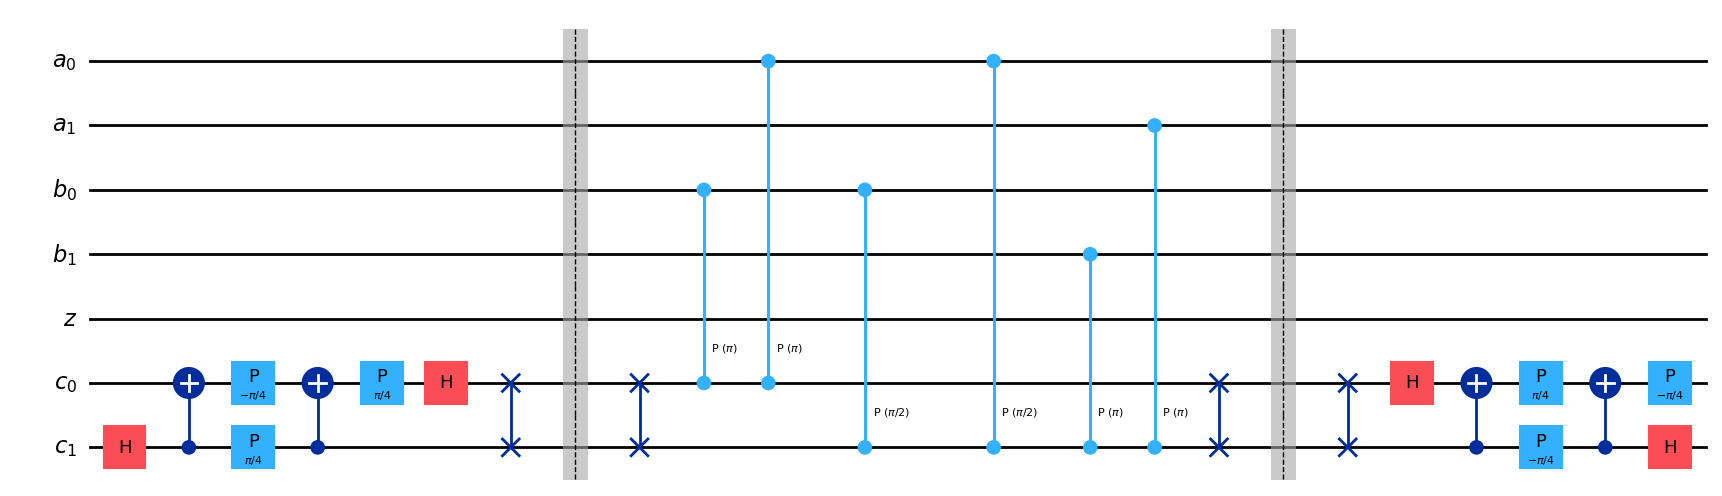

In [9]:
#Choose two numbers to add
d=2
num1 = 0
num2 = 3
n_qubits = 2**d
print("The expected result should be", (num1+num2)%n_qubits)
print("The obtained result is", result(number_input(num1,num2,0,d,0).evolve(Qadd(d)),d,0))
Qadd(d).draw(output="mpl")

### Benchmark Example of quantum addition with $n=3$

The expected result should be 3
The obtained result is 3


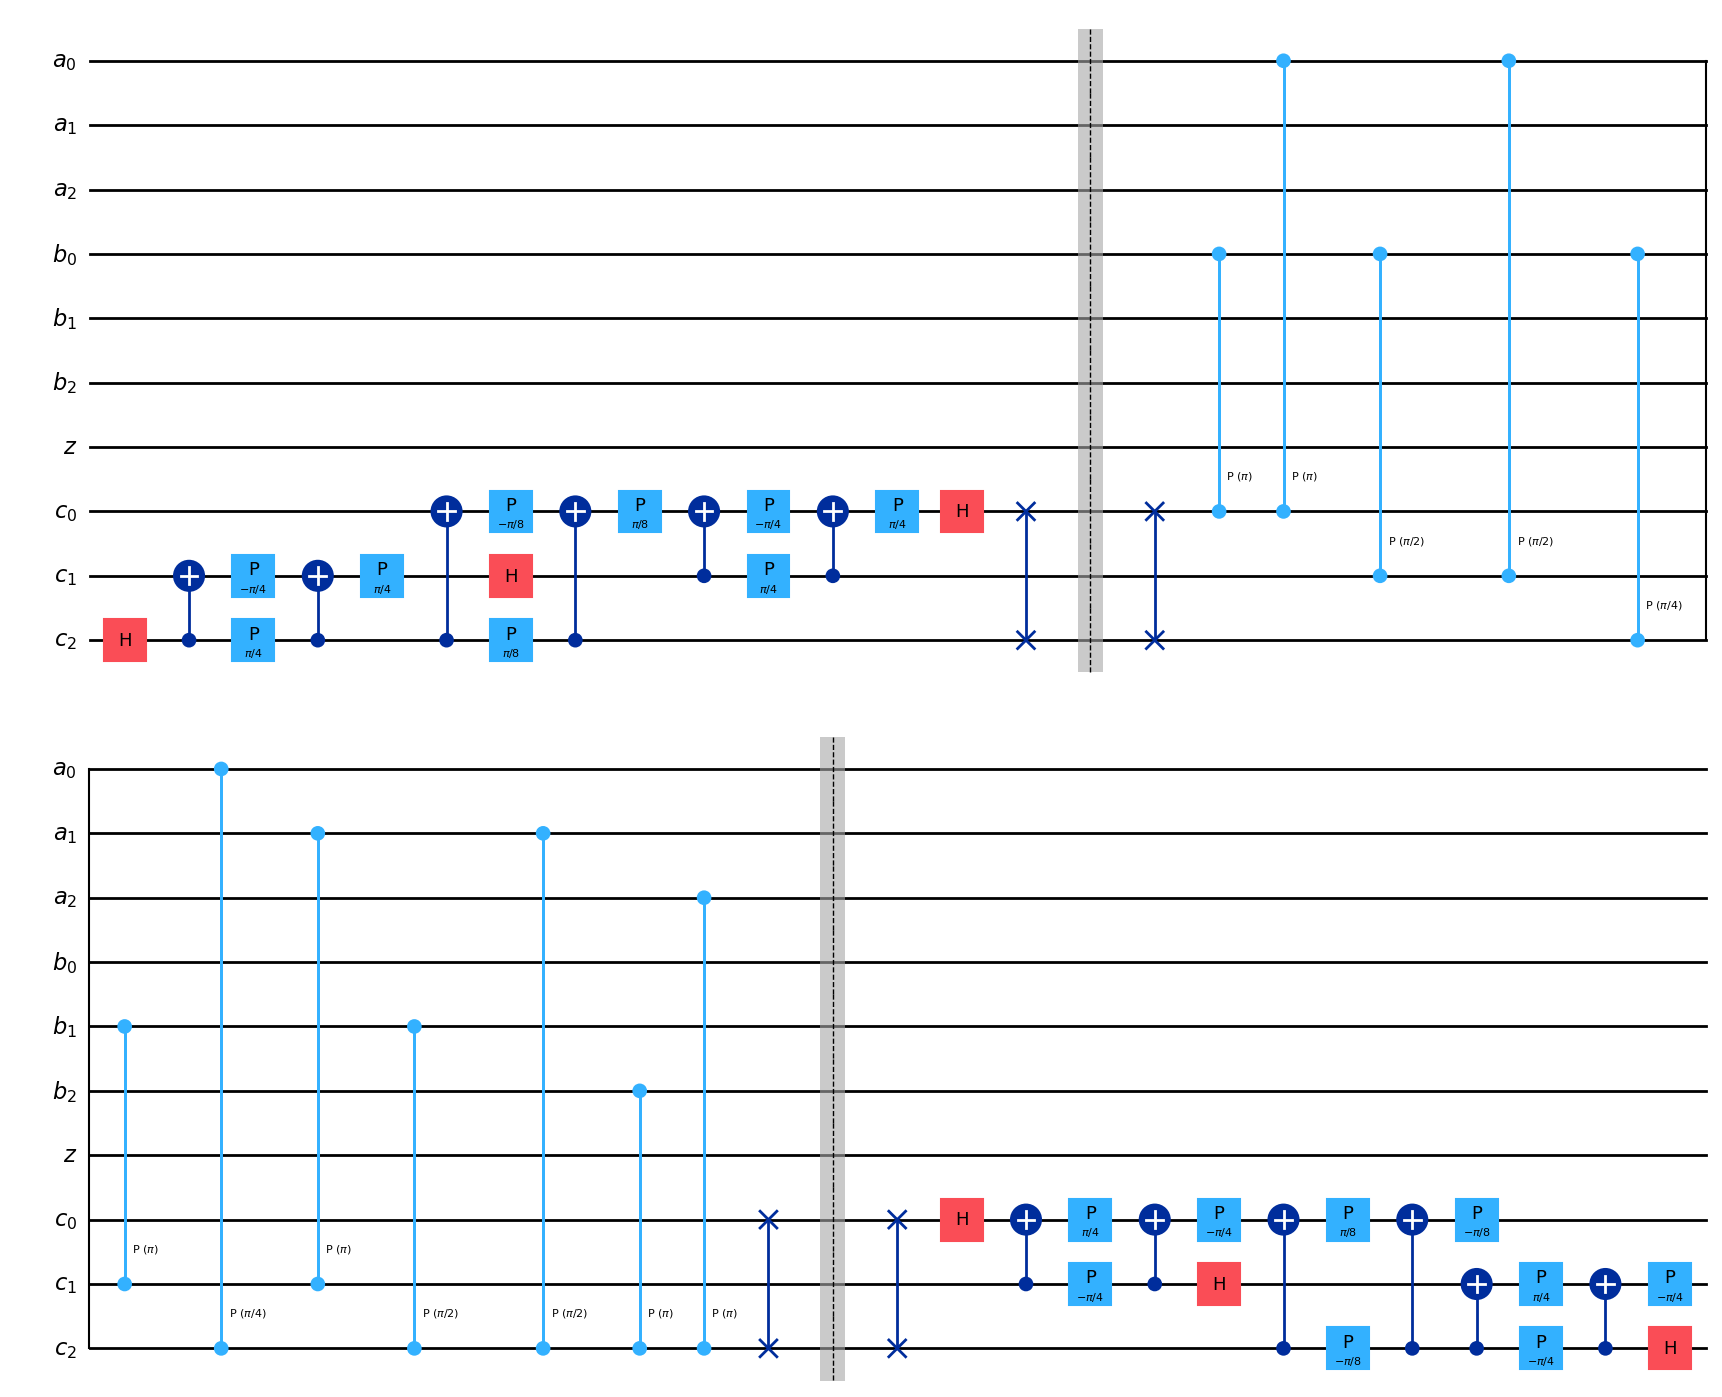

In [10]:
#Choose two numbers to add
d=3
num1 = 13
num2 = 6
n_qubits = 2**d
print("The expected result should be", (num1+num2)%n_qubits)
print("The obtained result is", result(number_input(num1,num2,0,d,0).evolve(Qadd(d)),d,0))
Qadd(d).draw(output="mpl")

### Benchmark Example of quantum addition with $n=4$

The expected result should be 3
The obtained result is 3


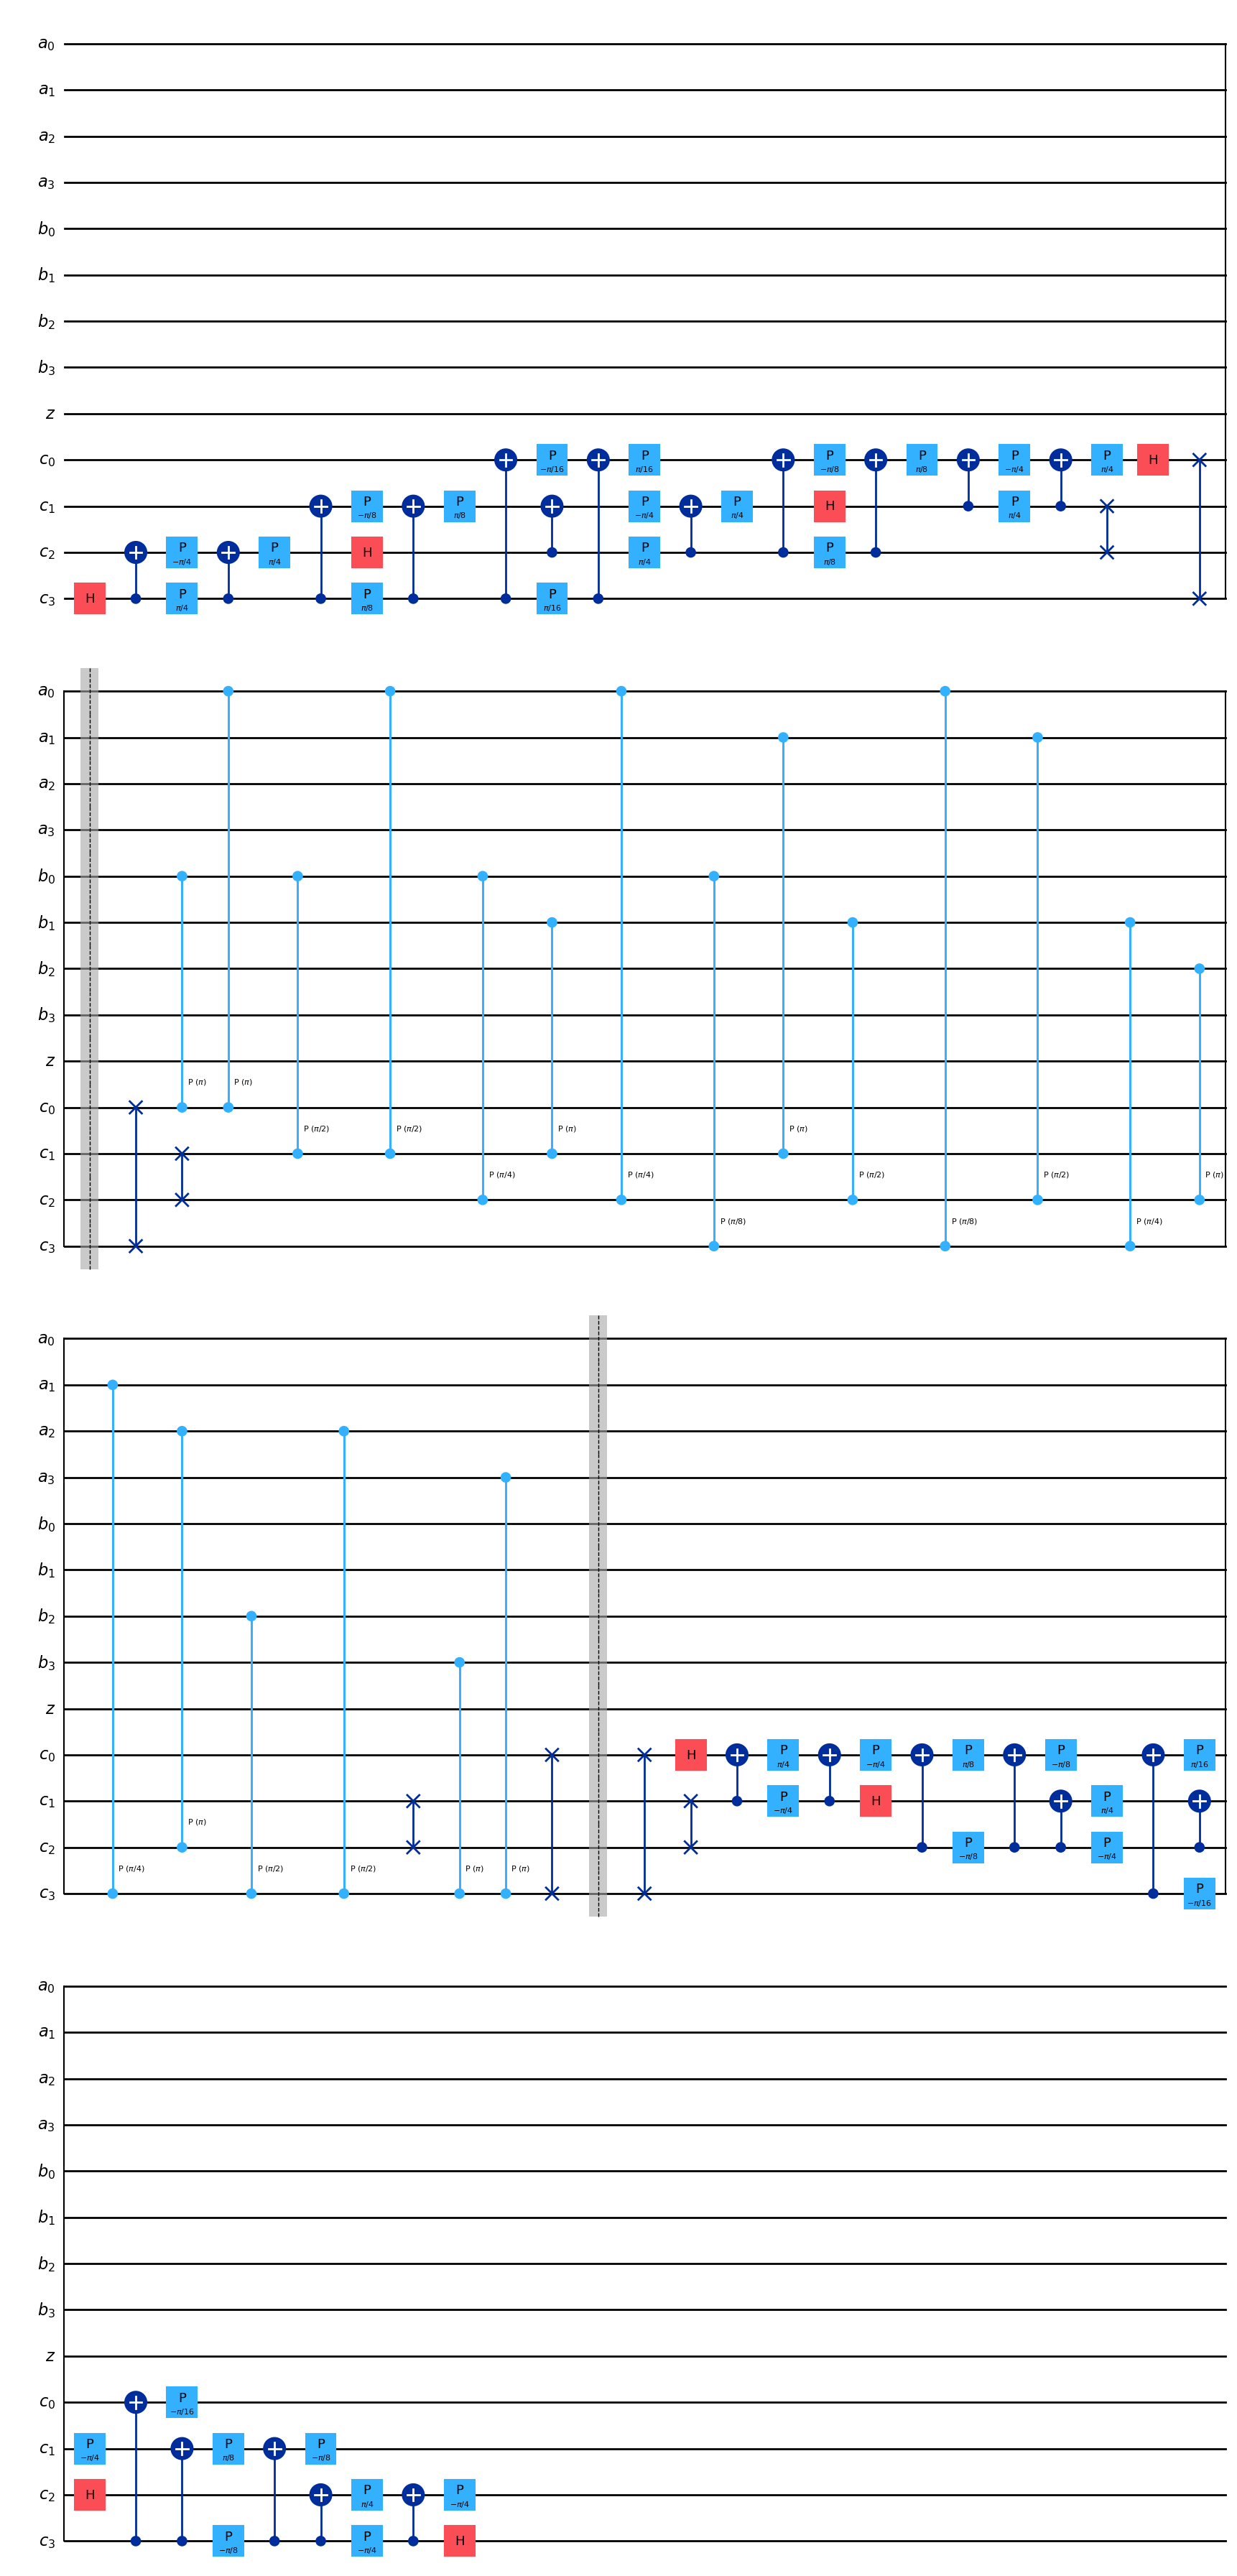

In [11]:
#Choose two numbers to add
d=4
num1 = 7
num2 = 12
n_qubits = 2**d
print("The expected result should be", (num1+num2)%n_qubits)
print("The obtained result is", result(number_input(num1,num2,0,d,0).evolve(Qadd(d)),d,0))
Qadd(d).draw(output="mpl")

## Quantum Multiplication <a name = "mult"></a>

### Algorithm

Again we will start by applying the QFT on $|c\rangle = |0\rangle$, such that we obtain $|\phi(0)\rangle$. Our goal is then to turn $|\phi(0)\rangle$ to $|\phi(ab)\rangle$ using a series of rotations. Let's decompose $ A \equiv ab = \sum_{i=1,j=1}^na_ib_j 2^{i+j-2} = \sum_{k'=1}^{2n-1} A_{k'} 2^{k'-1}$ where $k' = i+j-1$ (again some of the higher powers of $k$ are not going to matter since they only lead to phase rotations by $2\pi$).

So,

\begin{equation}
|\phi_k(A)\rangle =\frac{1}{\sqrt{2}} (|0\rangle + e^{2\pi i A/2^k}|1\rangle)
\end{equation}
where (using the equation we derived in the Section on [QFT](#FT)) we can write
\begin{equation}
e^{2\pi i A/ 2^k} = \prod_{k'=1}^k e^{2\pi i A_{k'}/2^k}
\end{equation}
Multiplication is now reduced to implementing the phase rotations for all $i,j$ satisfying $k' = i+j - 1$ and for each $\phi_k$. The only difference is that we have to control the rotation by the 2 qubits $a_i b_j$ since $A_k' = a_i b_j$. So our rotation operator (having 2 control qubits and 1 target qubit) now looks like 
\begin{equation}
R_{k'} = \begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & e^{2 \pi i /2^{k'}} \end{pmatrix}
\end{equation}


In [12]:
from qiskit.circuit.library import UnitaryGate

def indices_ij(m):
    i_arr = np.array([], dtype='int')
    j_arr = np.array([], dtype='int')
    for i in range(1,m+1):
        for j in range(1,m+1):
            if m == (i+j-1):
                i_arr = np.append(i_arr,i)
                j_arr = np.append(j_arr,j)
    return i_arr, j_arr

def Qmult(n):
    ### Now let's try multiplication

    qr_b = QuantumRegister(size=n, name="b")
    qr_a = QuantumRegister(size=n, name="a")
    qr_z = QuantumRegister(size=1, name="z")
    qr_c = QuantumRegister(size=n, name="c")
    qr_A = AncillaRegister(size=int(n*(n+1)*(n+2)/6), name="A")
    
    ancilla_counter=0
    
    #QFT_circuit = QuantumCircuit(qc_c2, qc_c1, qc_b2, qc_b1, qc_a2, qc_a1, name="QFT circuit")
    qc = QuantumCircuit(qr_a, qr_b,qr_z, qr_c, qr_A, name="QFT circuit")
    
    #Initial conditions
    #qc.x(qc_b1)
    #qc.x(qc_b2)
    #qc.x(qc_a1)
    #qc.x(qc_a2)
    
    
    #Apply Fourier Transform
    qc.compose(quantum_fourier_transform(n), qubits = qr_c[::-1],inplace=True)
    
    qc.barrier()
    
    for q, p in zip(qr_c[:n >> 1], reversed(qr_c[n >> 1:])):
        qc.swap(q, p)
    
    ##Bunch of ccp gates
    
    for m in range(1,n+1):
        #print("m is ",m)
        for rot_index in range(1,m+1):
            #print("rot is", rot_index)
            i_arr, j_arr = indices_ij(rot_index)
            for i,j in list(zip(i_arr,j_arr)):
                phase=2*np.pi/2**(m-rot_index+1)
                ccp_gate(qc,[qr_b[i-1],qr_a[j-1]],qr_c[m-1],qr_A[ancilla_counter],phase)
                ancilla_counter += 1
                        
                    
        
    
    
    
    for q, p in zip(qr_c[:n >> 1], reversed(qr_c[n >> 1:])):
        qc.swap(q, p)
    
    qc.barrier()

    ##Inverse Fourier Transform
    qc.compose(inverse_quantum_fourier_transform(n), qubits = qr_c[::-1],inplace=True)
    
    return qc

### Benchmark Example for multiplication with $n=2$

The expected result should be 2
The obtained result is 2


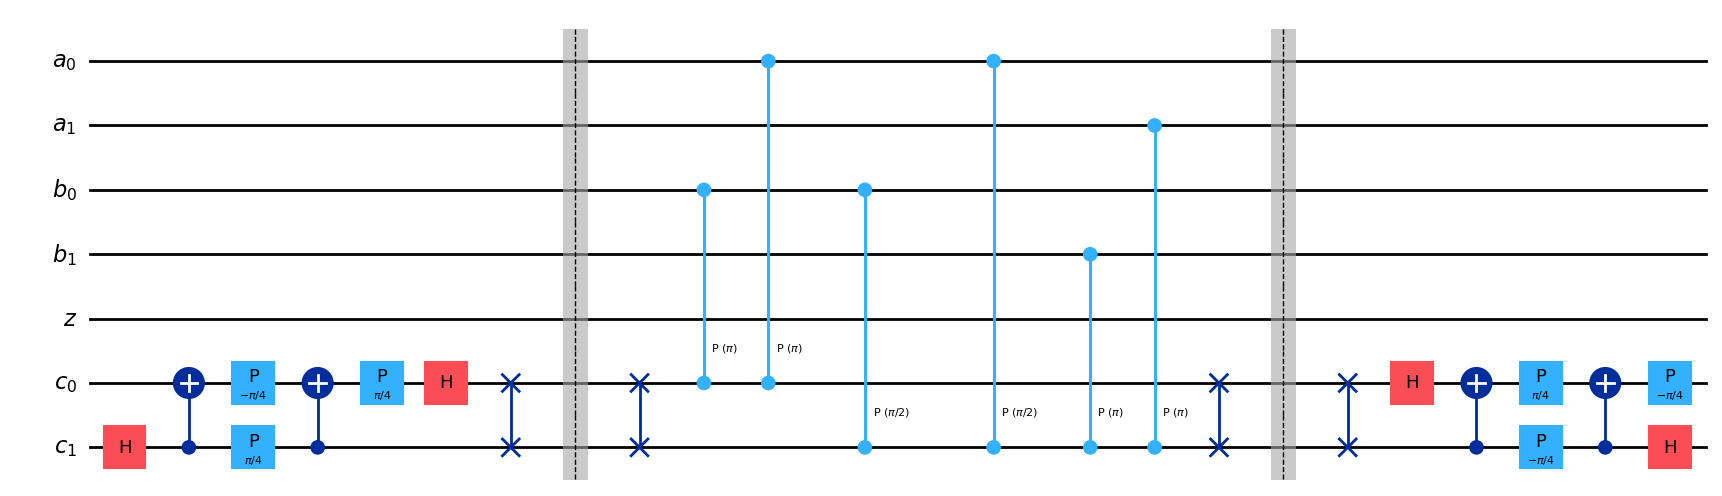

In [13]:
#Choose two numbers to multiply
d=2
num1 = 2
num2 = 3
n_qubits = 2**d
nA= int(d*(d+1)*(d+2)/6)
print("The expected result should be", (num1*num2)%n_qubits)
print("The obtained result is", result(number_input(num1,num2,0,d,nA).evolve(Qmult(d)),d,nA))
Qadd(d).draw(output="mpl")

### Benchmark Example for multiplication for $n=3$

The expected result should be 7
The obtained result is 7


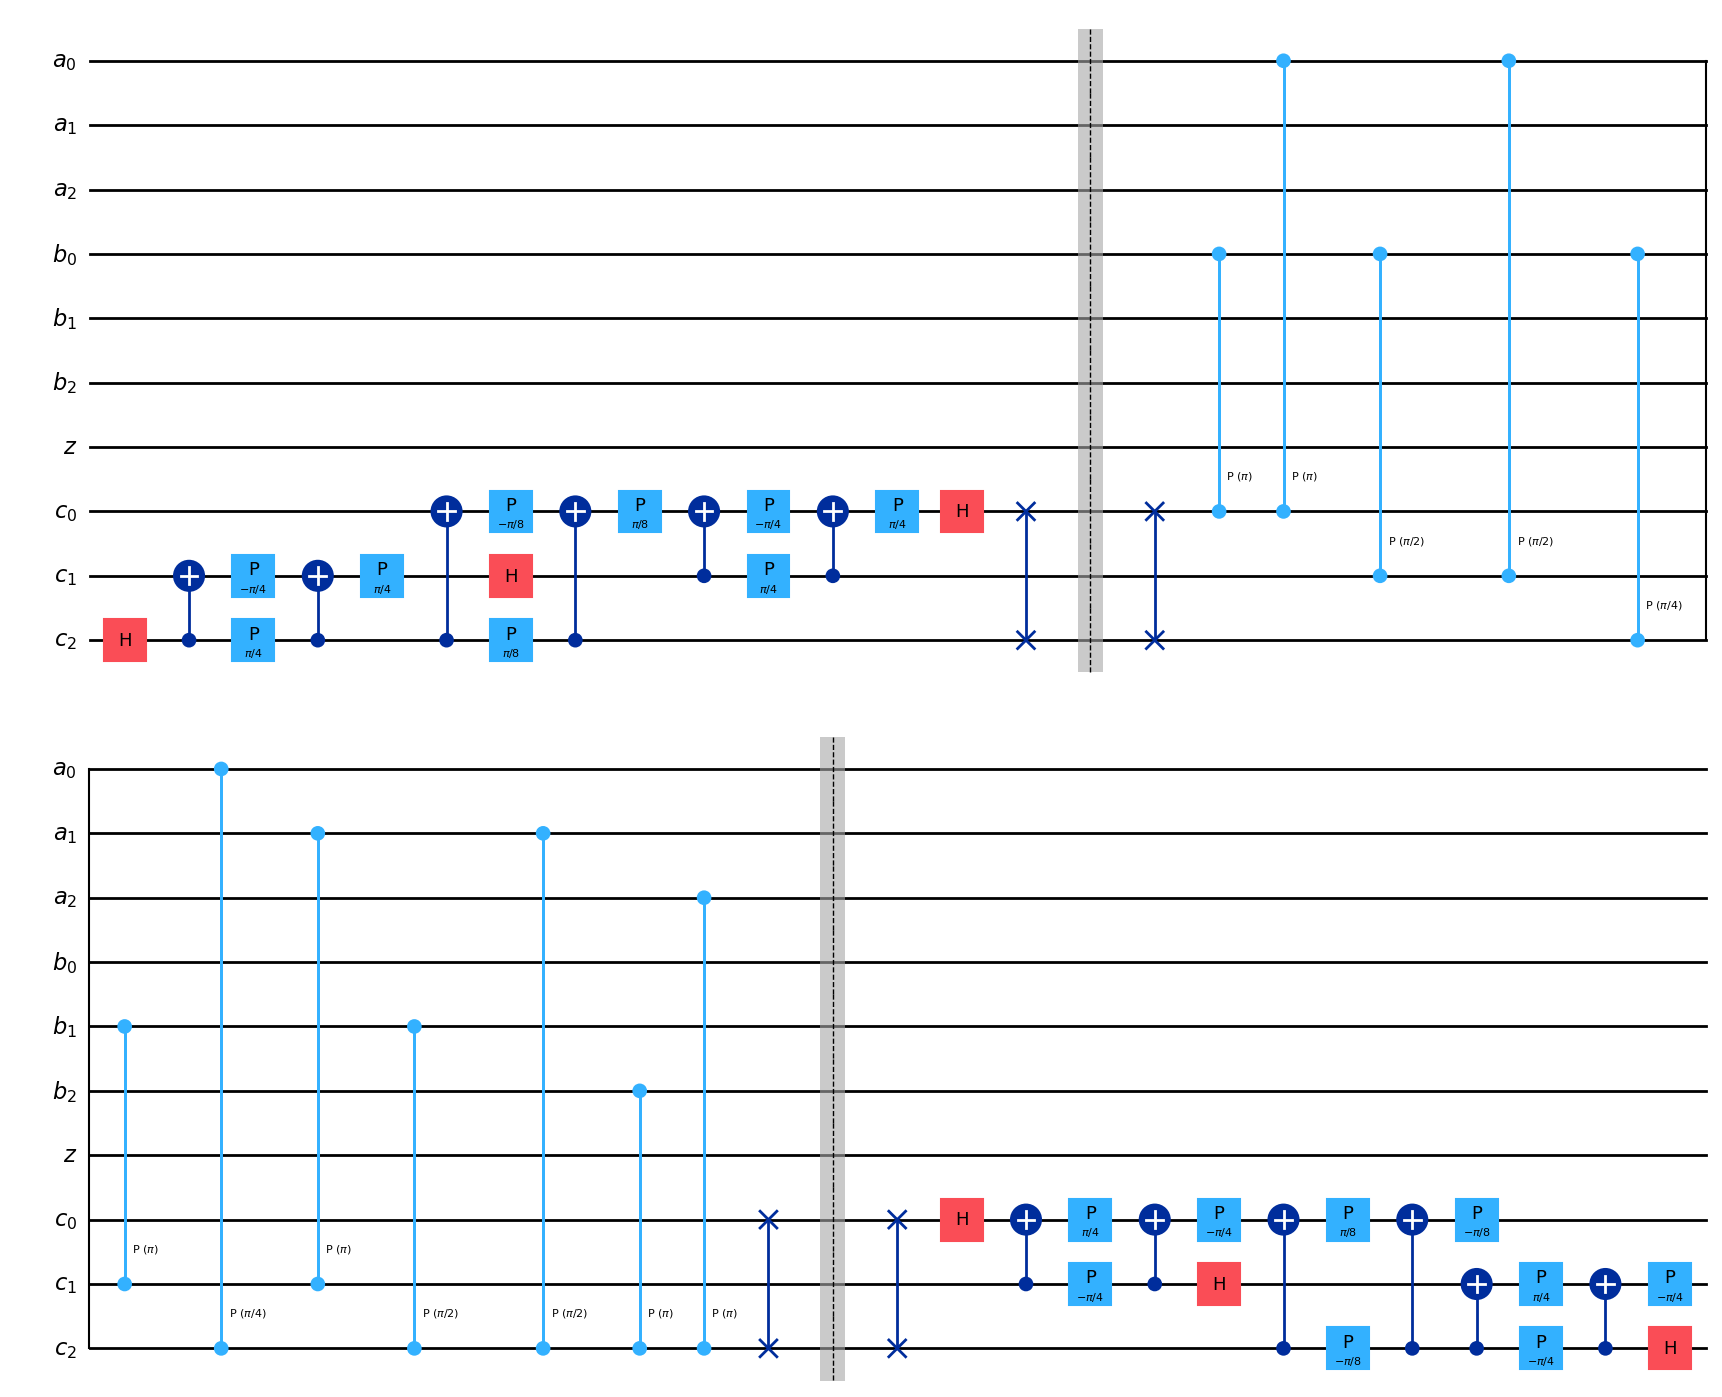

In [14]:
#Choose two numbers to multiply
d=3
num1 = 5
num2 = 3
n_qubits = 2**d
nA= int(d*(d+1)*(d+2)/6)
print("The expected result should be", (num1*num2)%n_qubits)
print("The obtained result is", result(number_input(num1,num2,0,d,nA).evolve(Qmult(d)),d,nA))
Qadd(d).draw(output="mpl")

## Quantum Calculator

Now we combine both addition and multiplication into one circuit QCalc controlled by a qubit $z$. <a name = "add+mult"></a>

In [15]:
def indices_ij(m):
    i_arr = np.array([], dtype='int')
    j_arr = np.array([], dtype='int')
    for i in range(1,m+1):
        for j in range(1,m+1):
            if m == (i+j-1):
                i_arr = np.append(i_arr,i)
                j_arr = np.append(j_arr,j)
    return i_arr, j_arr

def QCalc(n,nA):
    qr_a = QuantumRegister(size=n, name="a")
    qr_b = QuantumRegister(size=n, name="b")
    qr_z = QuantumRegister(size=1, name="z")
    qr_c = QuantumRegister(size=n, name="c")
    qr_A = AncillaRegister(size=nA, name="A")
    #qr_A = AncillaRegister(size=6, name="A")
    ancilla_counter=0

    qc = QuantumCircuit(qr_a, qr_b, qr_z, qr_c, qr_A, name="Calculator Circuit")
    qc.compose(quantum_fourier_transform(n), qubits = qr_c[::-1],inplace=True)

    qc.barrier()
    for q, p in zip(qr_c[:n >> 1], reversed(qr_c[n >> 1:])):
        qc.swap(q, p)

    #Add z as a control to all ccp gates in multiplication algorithm to perform multiplication if z=1
    for m in range(1,n+1):
        #print("m is ",m)
        for rot_index in range(1,m+1):
            #print("rot is", rot_index)
            i_arr, j_arr = indices_ij(rot_index)
            for i,j in list(zip(i_arr,j_arr)):
                phase=2*np.pi/2**(m-rot_index+1)
                cccp_gate(qc,[qr_b[i-1],qr_a[j-1],qr_z[0]],qr_c[m-1],[qr_A[ancilla_counter],qr_A[ancilla_counter+1]],phase)
                ancilla_counter+=2
    
    #Negate z to switch to addition
    qc.x(qr_z[0])
    
    #Assuming we only want to use addition or multiplication, we can reuse ancillas. If z is a mixed state, this will cause issues.
    #ancilla_counter = 0

    #Add z as a control to all cp gates in addition algorithm to perform addition if z=0 (which would now be switched to 1)
    for j, p in enumerate(qr_c, start=0): # is this algorithm fully quantum if I use if-else? Yes because this only helps in construction.
        for i in range(n):
            if i >j:
                pass
            else:
                q = qr_b[i]
                r = qr_a[i]
                #qc.cp(2*np.pi/2**(j+1-i), p,q)
                #qc.cp(2*np.pi/2**(j+1-i), p,r)
                ccp_gate(qc,[qr_z,q], p, qr_A[ancilla_counter], 2*np.pi/2**(j+1-i))
                ancilla_counter += 1
                ccp_gate(qc,[qr_z,r], p, qr_A[ancilla_counter], 2*np.pi/2**(j+1-i))
                ancilla_counter += 1

    #Negate z back to its original value
    qc.x(qr_z[0])

    for q, p in zip(qr_c[:n >> 1], reversed(qr_c[n >> 1:])):
        qc.swap(q, p)
    
    qc.barrier()

    ##Inverse Fourier Transform
    qc.compose(inverse_quantum_fourier_transform(n), qubits = qr_c[::-1],inplace=True)
    
    return qc

### Benchmark Example for multiplication for $n=1$

The expected result should be 1
The obtained result is 1


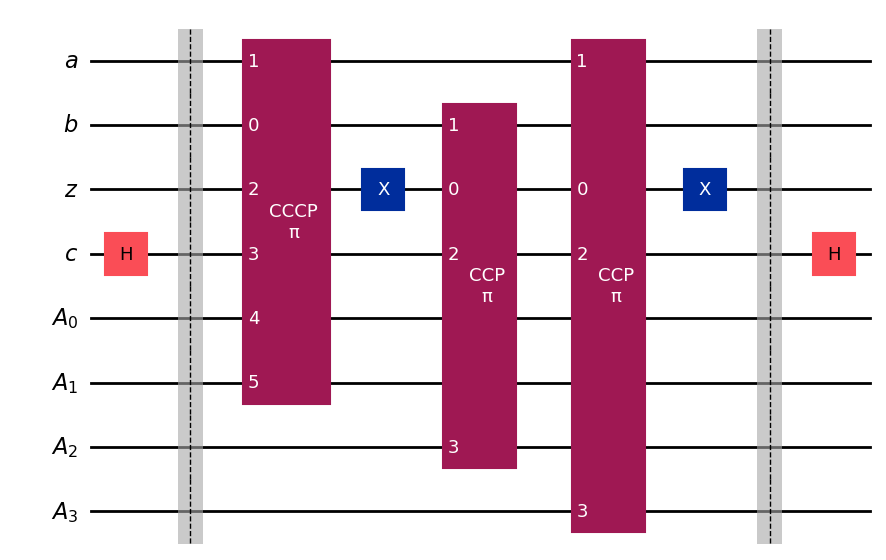

In [20]:
#Choose two numbers to multiply
d = 1
num1 = 0
num2 = 1
#z=0 for addition and z=1 for multiplication
z = 0
n_qubits = 2**d
n_ancilla = int(d*(d+1)+(d*(d+1)*(d+2)/3))
if z==0:
    print("The expected result should be", (num1+num2)%n_qubits)
elif z==1:
    print("The expected result should be", (num1*num2)%n_qubits)
qc=QCalc(d,n_ancilla)
print("The obtained result is", result(number_input(num1,num2,z,d,n_ancilla).evolve(qc),d,n_ancilla))
qc.draw(output="mpl")

### Benchmark Example for multiplication for $n=2$

The expected result should be 1
The obtained result is 1


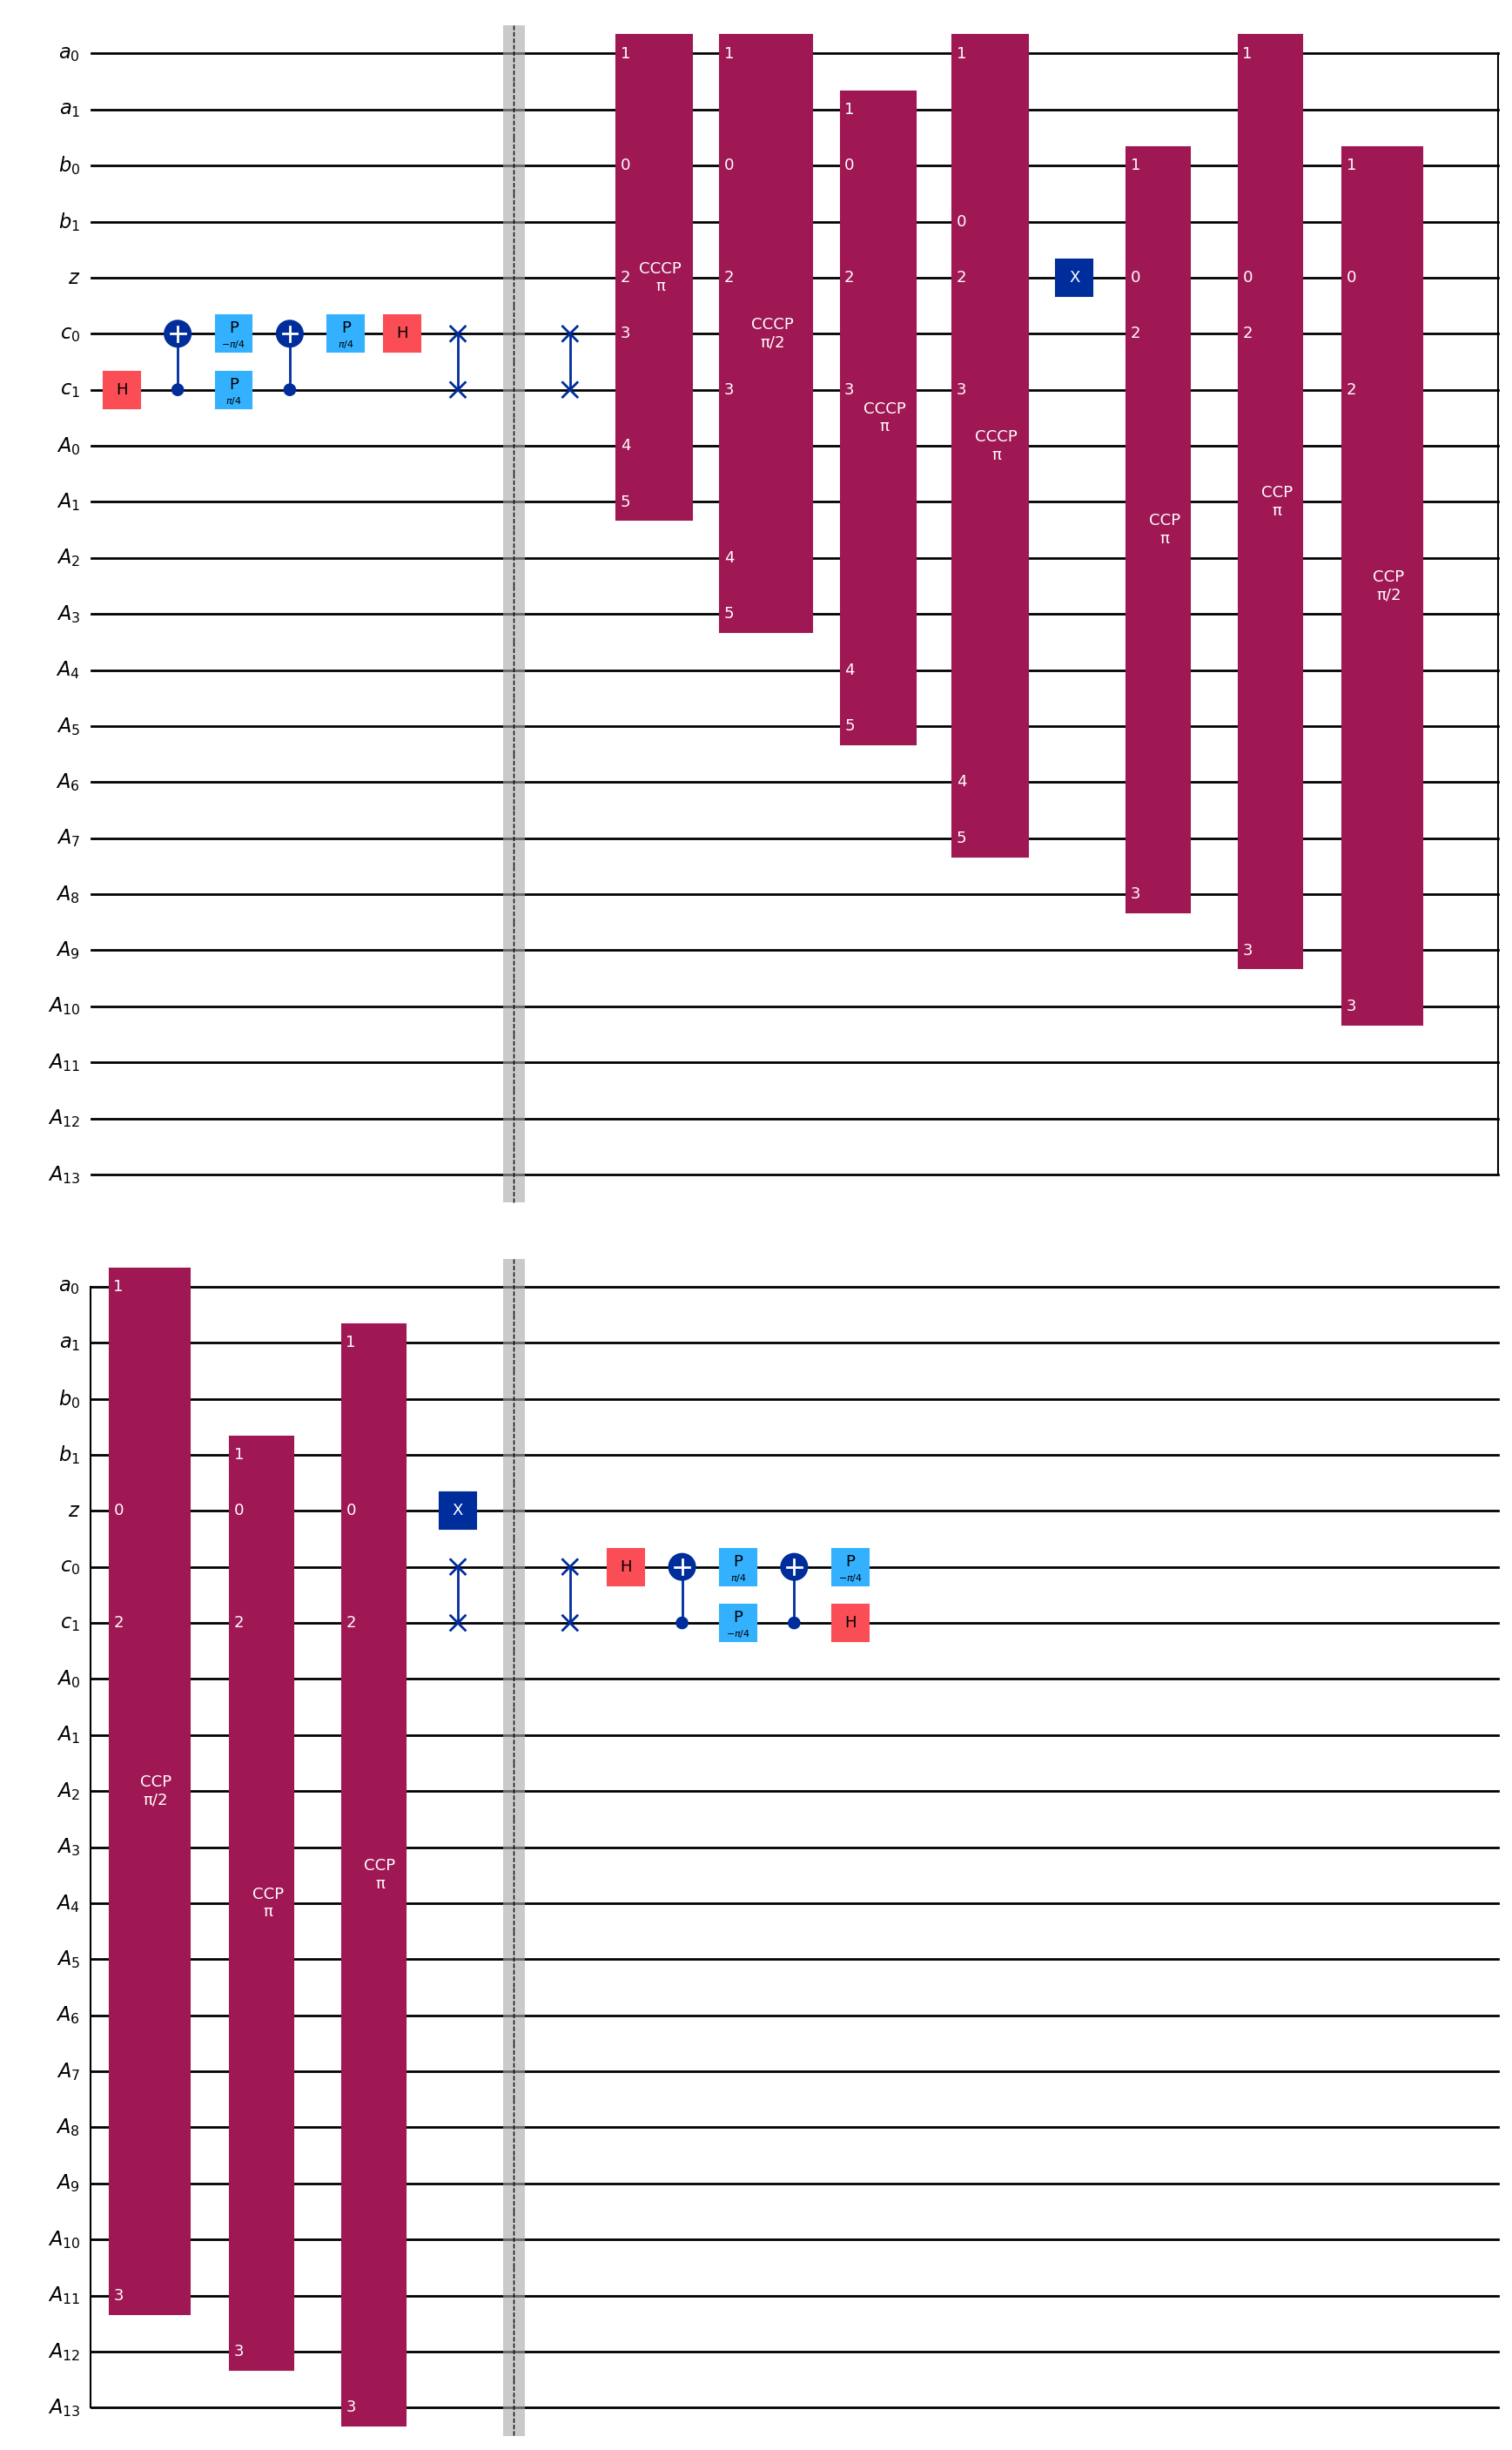

In [21]:
#Choose two numbers to multiply
d = 2
num1 = 2
num2 = 3
#z=0 for addition and z=1 for multiplication
z = 0
n_qubits = 2**d
n_ancilla = int(d*(d+1)+(d*(d+1)*(d+2)/3))
if z==0:
    print("The expected result should be", (num1+num2)%n_qubits)
elif z==1:
    print("The expected result should be", (num1*num2)%n_qubits)
qc=QCalc(d,n_ancilla)
print("The obtained result is", result(number_input(num1,num2,z,d,n_ancilla).evolve(qc),d,n_ancilla))
qc.draw(output="mpl")

Unfortunately, our laptops do not have enough space to demonstrate the $n=3$ case. Though we are confident our circuits would be correct, our methods are highly inefficient and use a very large number of ancillas.

## Analysis of Complexities <a name = "Complexities"></a>

### Gate Count

By far are highest gate counts in the $d\to\infty$ limit come from the multiplication algorithm. Here, we use $d(d+1)(d+2)/6$ CCCP gates which scales as $\mathcal{O}(d^3)$ whereas our other algorithms scale by at worst $\mathcal{O}(d^2)$. Hence, the gate count of our algorithm scales as $\mathcal{O}(d^3)$.

### Gate Depth

Again, our multiplication algorithm has the largest depth. We are limited by the amount of operations sequentially acting on the $c_d$ qubit. That is, the digit of $\ket{c}_d$ that has the largest power of 2 needing the most phase shifts. For this qubit, $d$ phase shifts are performed. Hence, our gate depth scales as $\mathcal{O}(d)$

### Number of Ancillas

We found that we were unable to "reuse" ancillas in the addition and multiplication algorithms without breaking the functionality. Though we could "reset" each ancilla we use with a measurement and a classical bit, these are strictly forbidden from this exercise. Unsurprisingly, we need the largest amount on ancillas from our multiplication algorithm. At two ancillas per CCCP gate, we require $d(d+1)(d+2)/3$ ancillas. Hence, our number of ancillas scale as $\mathcal{O}(n^3)$